In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
batch_size = 128
my_transforms = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.ToTensor()]
)

train_dataset = datasets.FashionMNIST(download=True,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=True, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
import os
import torchvision

# Suppose you are trying to load pre-trained resnet model in directory- models\resnet

os.environ['TORCH_HOME'] = '../models' #setting the environment variable


In [4]:
vgg = torchvision.models.vgg16(pretrained=True) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to ../models/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [5]:
vgg.features[0] = nn.Conv2d(1,64,kernel_size=(3,3), stride=(1,1), padding=(1,1))
vgg.classifier.out_features = 10

In [6]:
for param in vgg.features.parameters():
    param.requires_grad = False

In [7]:
def accuracy(y_hat,y):
    return (y_hat.argmax(1)==y).sum()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [9]:
def full_accuracy(net, data_iter):
    net.eval()
#     device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'
    net = net.to(device)
    
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)

            total_acc += accuracy(y_hat, y)
            total_num += y.numel()
    
    return total_acc/total_num

In [10]:
def train_net(net):
    
    train_loss = []
    train_acc = []
    test_acc = []

    net= net.to(device)
    for epoch in range(num_epochs):

        acc_value = 0
        total_number = 0
        total_loss= 0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            total_loss += loss.item()
            acc_value += accuracy(outputs, labels)
            total_number += labels.numel()

        with torch.no_grad():

            print(f"\tEpoch {epoch} : Statistics: ")
            print(f'\tcurrent train loss : {total_loss} / {total_number} : {float(total_loss/total_number)}')
            print(f'\tcurrent train acc : {acc_value}/{total_number} : {float(acc_value/total_number)}')
            print(f'\tcurrent test acc : {float(full_accuracy(net, test_dataloader))}')


            train_loss.append(float(total_loss/total_number))
            test_acc.append(float(full_accuracy(net, test_dataloader)))
            train_acc.append(float(acc_value/total_number))
    
    return train_loss, test_acc, train_acc

In [11]:
optimizer = torch.optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [12]:
num_epochs=6
train_loss, test_acc, train_acc = train_net(vgg)

	Epoch 0 : Statistics: 
	current train loss : 565.9463684558868 / 60000 : 0.009432439474264781
	current train acc : 36252/60000 : 0.604200005531311
	current test acc : 0.7755999565124512
	Epoch 1 : Statistics: 
	current train loss : 250.9573773741722 / 60000 : 0.0041826229562362035
	current train acc : 48423/60000 : 0.8070499897003174
	current test acc : 0.8098999857902527
	Epoch 2 : Statistics: 
	current train loss : 213.90076684951782 / 60000 : 0.003565012780825297
	current train acc : 49989/60000 : 0.8331500291824341
	current test acc : 0.8375999927520752
	Epoch 3 : Statistics: 
	current train loss : 192.9448747932911 / 60000 : 0.003215747913221518
	current train acc : 50983/60000 : 0.8497166633605957
	current test acc : 0.8456999659538269
	Epoch 4 : Statistics: 
	current train loss : 179.91643795371056 / 60000 : 0.002998607299228509
	current train acc : 51525/60000 : 0.8587499856948853
	current test acc : 0.8441999554634094
	Epoch 5 : Statistics: 
	current train loss : 170.21968315

finished


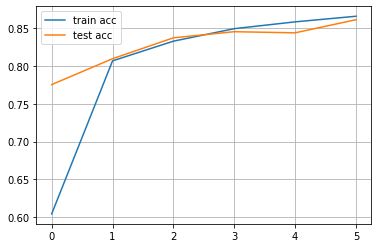

In [14]:
print("finished")

import matplotlib.pyplot as plt
num_epochs = num_epochs
# plt.plot(range(num_epochs), train_loss, label='train loss')
plt.plot(range(num_epochs), train_acc, label = 'train acc')
plt.plot(range(num_epochs), test_acc, label = 'test acc')
plt.grid(True)
plt.legend()
plt.show()

### Exercises

1. When printing out the dimensions of the layers we only saw 8 results rather than 11. Where
did the remaining 3 layer information go?

* in maxpool

2. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs
more GPU memory. Analyze the reasons for this.

* it has more conv layers

3. Try changing the height and width of the images in Fashion-MNIST from 224 to 96. What
influence does this have on the experiments?

* it willrun faster

4. Refer to Table 1 in the VGG paper (Simonyan & Zisserman, 2014) to construct other common
models, such as VGG-16 or VGG-19.

* it can be done but my GPU says hi